# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

/home/wolph/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Carga de los datos

In [2]:
df = pd.read_csv("train_set.csv", dtype={
    'bike_id':'category',
    'trip_route_category':'category',
    'passholder':'category'})
df.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


# Análisis exploratorio de los datos.

Funciones que se utilizan en el notebook

In [12]:
def add_timeformat(df):
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

def make_boxplot(df):
    
    fig, axes = plt.subplots(2,4, figsize=(15,9))

    axes[0][0].boxplot(x = df['duration'],)
    axes[0][0].set_title("duration")
    axes[0][1].boxplot(x= df['start_lat'])
    axes[0][1].set_title("start_lat")
    axes[0][2].boxplot(x= df['start_lon'])
    axes[0][2].set_title("start_lon")
    axes[0][3].boxplot(x= df['end_lat'])
    axes[0][3].set_title("end_lat")
    axes[1][0].boxplot(x= df['end_lon'])
    axes[1][0].set_title("end_lon")
    axes[1][1].boxplot(x= df['plan_duration'])
    axes[1][1].set_title("plan_duration")
    axes[1][2].boxplot(x= df['start_station'])
    axes[1][2].set_title("start_station")
    axes[1][3].boxplot(x= df['end_station'])
    axes[1][3].set_title("end_station")

def add_schedule(data):
    data['schedule'] = 'morning'
    for i in range(len(data)):
        if data['start_time'][i].hour in [5,6,7,8,9,10,11,12]:
            data['schedule'][i] = 'morning'
        elif data['start_time'][i].hour in [13,14,15,16,17,18]:
            data['schedule'][i] = 'afternoon'
        elif data['start_time'][i].hour in [19,20,21]:
            data['schedule'][i] = 'evening'
        elif data['start_time'][i].hour in [22,23,0,1,2,3,4]:
            data['schedule'][i] = 'night'

def add_year(data):
    data['year'] = 2016
    for i in range(len(data)):
        data['year'][i] = data['start_time'][i].year
        

Asignar el formato de fecha a las columnas start_time y end_time.

In [4]:
add_timeformat(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              700000 non-null  int64         
 1   duration             700000 non-null  int64         
 2   start_time           700000 non-null  datetime64[ns]
 3   end_time             700000 non-null  datetime64[ns]
 4   start_lat            694437 non-null  float64       
 5   start_lon            694437 non-null  float64       
 6   end_lat              681426 non-null  float64       
 7   end_lon              681426 non-null  float64       
 8   bike_id              700000 non-null  category      
 9   plan_duration        699792 non-null  float64       
 10  trip_route_category  700000 non-null  category      
 11  passholder_type      697424 non-null  object        
 12  start_station        700000 non-null  int64         
 13  end_station   

Explorar el conjunto de datos para ver si no existen valores nulos.

Checking for null values

In [5]:
## missing values summary
print("Missing Value Summary\n{}".format("-"*35))
null_values = df.isnull().sum(axis = 0)
print(null_values)

Missing Value Summary
-----------------------------------
trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5563
start_lon               5563
end_lat                18574
end_lon                18574
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64


Text(0.5, 1.0, 'Columns that contains null values')

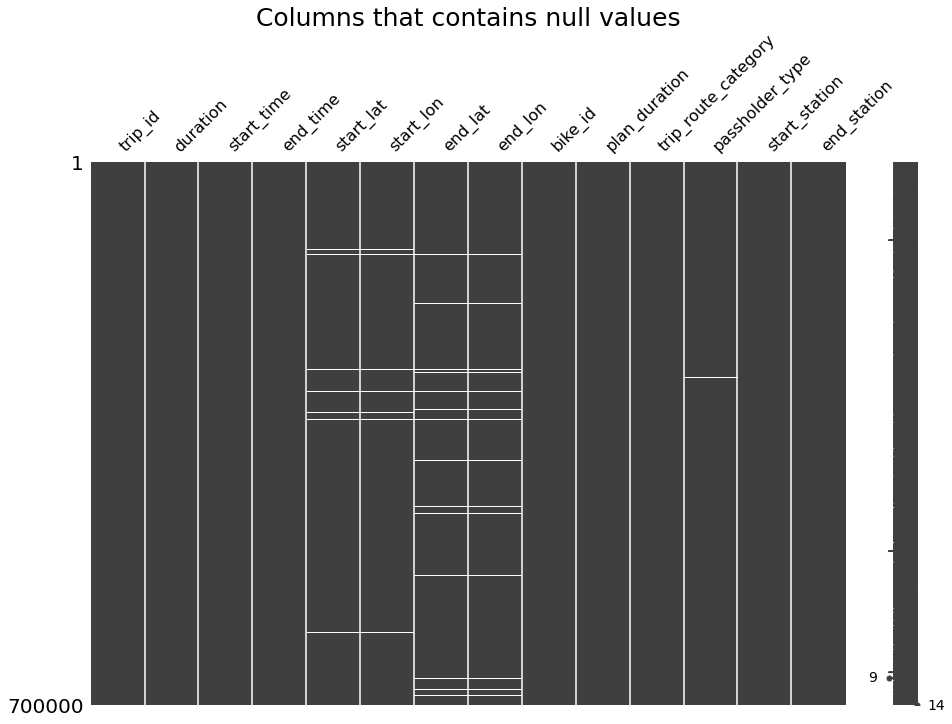

In [6]:
import missingno as msn

msn.matrix(df,figsize=(15,10))
plt.title("Columns that contains null values", fontsize=25)

Text(0.5, 1.0, 'Valid values for each feature')

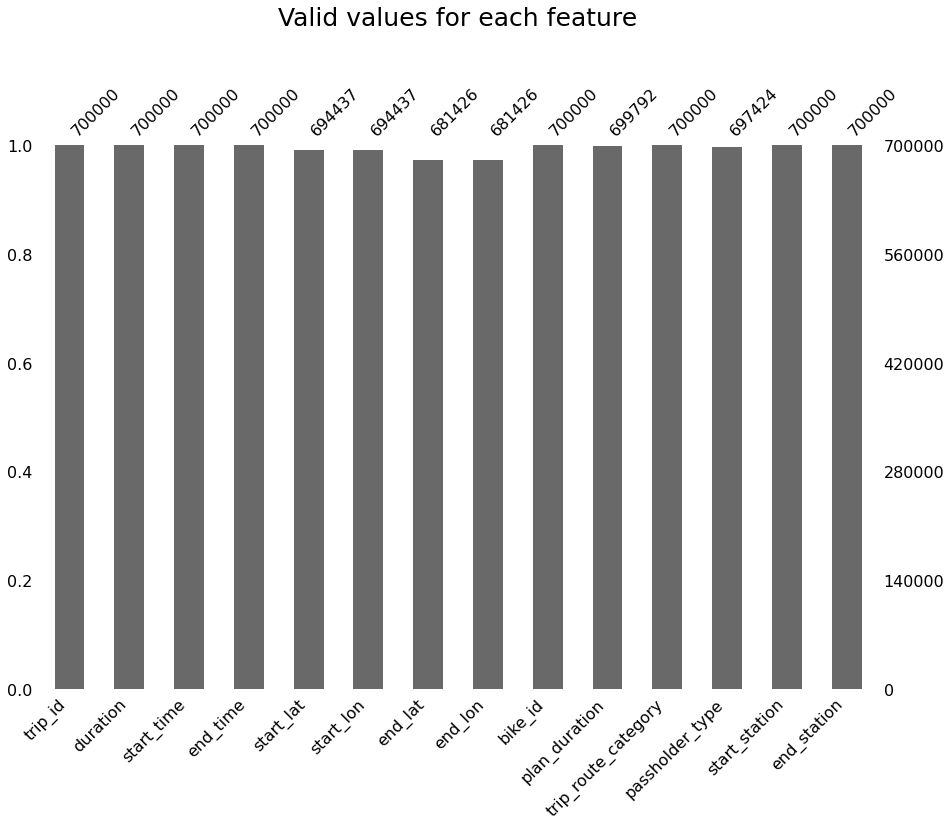

In [7]:
msn.bar(df, figsize=(15,10))
plt.title("Valid values for each feature",fontsize=25, pad=120)

Eliminar valores nulos dentro del conjunto de datos.

In [8]:
df.dropna(inplace=True)
df.isnull().sum()

# type(df)

trip_id                0
duration               0
start_time             0
end_time               0
start_lat              0
start_lon              0
end_lat                0
end_lon                0
bike_id                0
plan_duration          0
trip_route_category    0
passholder_type        0
start_station          0
end_station            0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 675626 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              675626 non-null  int64         
 1   duration             675626 non-null  int64         
 2   start_time           675626 non-null  datetime64[ns]
 3   end_time             675626 non-null  datetime64[ns]
 4   start_lat            675626 non-null  float64       
 5   start_lon            675626 non-null  float64       
 6   end_lat              675626 non-null  float64       
 7   end_lon              675626 non-null  float64       
 8   bike_id              675626 non-null  category      
 9   plan_duration        675626 non-null  float64       
 10  trip_route_category  675626 non-null  category      
 11  passholder_type      675626 non-null  object        
 12  start_station        675626 non-null  int64         
 13  end_station   

In [14]:
df.describe()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station
count,6.756260e+05,675626.000000,675626.000000,675626.000000,675626.000000,675626.000000,675626.000000,675626.000000,675626.000000
mean,1.063468e+08,31.093780,34.044957,-118.253718,34.043957,-118.260350,44.824709,3487.031890,3486.696184
std,4.513893e+07,92.754909,0.320028,2.295352,0.290402,2.061822,92.207201,611.564384,611.253304
min,8.369648e+06,1.000000,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000
25%,7.405582e+07,7.000000,34.038609,-118.280182,34.037460,-118.280510,1.000000,3030.000000,3031.000000
50%,1.167977e+08,13.000000,34.046612,-118.256668,34.046520,-118.256980,30.000000,3064.000000,3064.000000
75%,1.397153e+08,25.000000,34.051941,-118.246422,34.050911,-118.246422,30.000000,4211.000000,4212.000000
max,1.794576e+08,1440.000000,55.705528,118.238258,55.705528,37.606541,999.000000,4594.000000,4594.000000


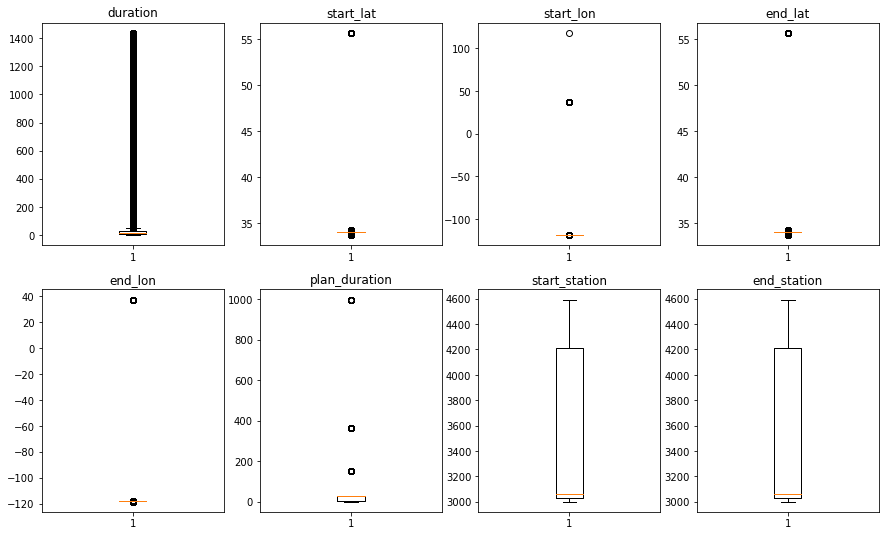

In [15]:
make_boxplot(df)

## Removal of outliers

In [16]:
df = df[df.end_lon<-118]
df = df[df.end_lat<35]
df = df[df.start_lon<-118]
df = df[df.start_lat<40].reset_index(drop=True)
df

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675439,83666862,17,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,30.0,One Way,Monthly Pass,3032,4220
675440,132547303,9,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,30.0,One Way,Monthly Pass,3036,3014
675441,67332628,6,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,365.0,One Way,Flex Pass,3032,3007
675442,114846232,3,2019-02-04 14:16:00,2019-02-04 14:19:00,34.045181,-118.250237,34.045540,-118.256668,12195,1.0,One Way,Walk-up,3067,3006


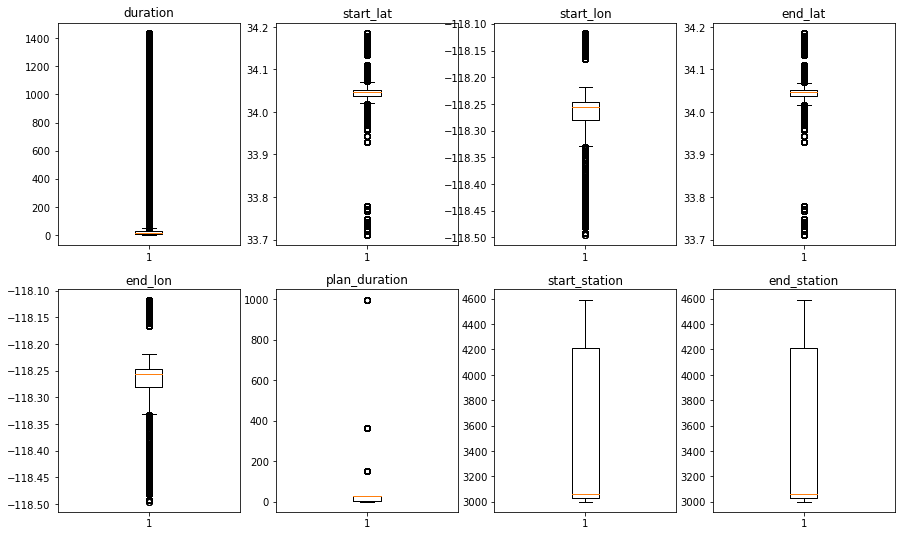

In [17]:
make_boxplot(df)

### Saturación del servicio

Se desea saber como se comporta la demanda para cada Plan.

Para un mejor entendimiento sobre los horarios de uso, se procede a agregar una nueva columna que tiene los siguientes valores: morning, afternoon, evening, night.

In [18]:
add_schedule(df)

<ipython-input-12-166b627e646b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['schedule'][i] = 'morning'
<ipython-input-12-166b627e646b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['schedule'][i] = 'afternoon'
<ipython-input-12-166b627e646b>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['schedule'][i] = 'night'
<ipython-input-12-166b627e646b>:34: SettingWithCopyWarning: 
A value is trying to be set on a cop

Agregar otra columna con el año de cada uso.

In [19]:
add_year(df)

<ipython-input-12-166b627e646b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'][i] = data['start_time'][i].year


In [20]:
df.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,schedule,year
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127,morning,2018
1,46560345,32,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062,afternoon,2017
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062,morning,2019
3,129547190,138,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311,morning,2019
4,136619463,14,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443,afternoon,2020


Text(0.5, 1.0, 'Comportamiento de la demanda según cada plan')

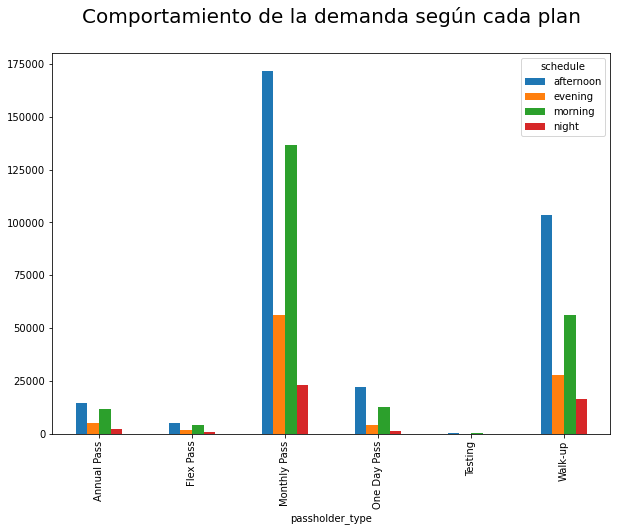

In [21]:
table1 = pd.pivot_table(df, index='passholder_type', columns='schedule', values="trip_id", aggfunc=np.count_nonzero)
table1.plot(kind='bar', figsize=(10,7))
plt.title("Comportamiento de la demanda según cada plan", fontsize=20, pad=30)

Text(0.5, 1.0, 'Uso de bicicletas con el tiempo')

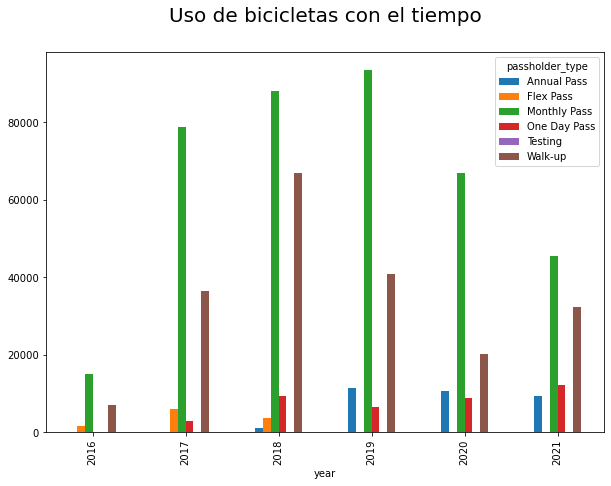

In [22]:
table1 = pd.pivot_table(df, index='year', columns='passholder_type', values="trip_id", aggfunc=np.count_nonzero)
table1.plot(kind='bar', figsize=(10,7))
plt.title("Uso de bicicletas con el tiempo", fontsize=20, pad=30)

# Predictive analysis

Aplicar one-hot-encoding

In [98]:
data_preprocessed = df.copy()

In [99]:
to_be_encoded = data_preprocessed.loc[:,['trip_route_category','passholder_type','bike_id','schedule']]

lab_enc = preprocessing.LabelEncoder()
encoding_tripRoute = lab_enc.fit_transform(to_be_encoded['trip_route_category'])
data_preprocessed['trip_route_category'] = encoding_tripRoute
encoding_passholder = lab_enc.fit_transform(to_be_encoded['passholder_type'])
data_preprocessed['passholder_type'] = encoding_passholder


In [100]:
lab_enc_bike = preprocessing.LabelEncoder()
encoding_bike = lab_enc_bike.fit_transform(to_be_encoded['bike_id'])
data_preprocessed['bike_id'] = encoding_bike
encoding_schedule = lab_enc_bike.fit_transform(to_be_encoded['schedule'])
data_preprocessed['schedule'] = encoding_schedule

In [101]:
data_preprocessed.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,schedule,year
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,814,1.0,1,5,4127,4127,2,2018
1,46560345,32,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,4306,0.0,0,5,3057,3062,0,2017
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,984,30.0,0,2,3022,3062,2,2019
3,129547190,138,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,2763,1.0,0,3,4304,4311,2,2019
4,136619463,14,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,2894,30.0,0,2,4266,4443,0,2020


<AxesSubplot:>

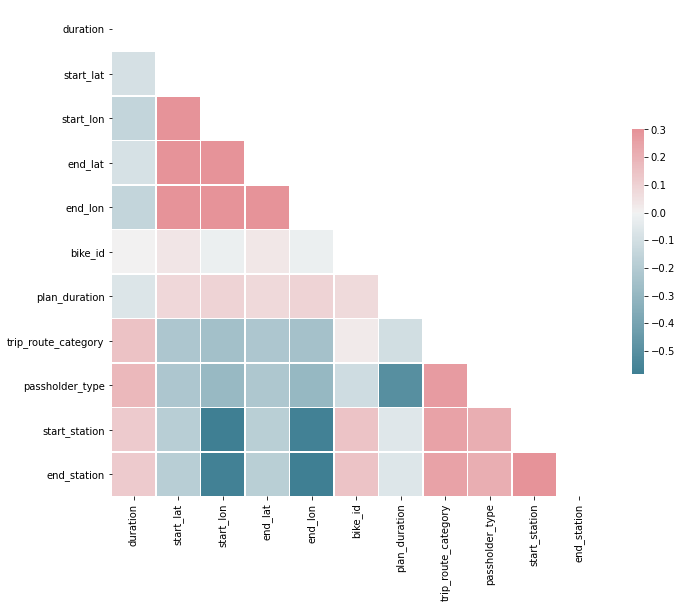

In [102]:
columns = ['duration','start_lat','start_lon','end_lat','end_lon','bike_id',\
    'plan_duration','trip_route_category','passholder_type','start_station','end_station']
    
corr = data_preprocessed[columns].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(figsize=(11,9))
cmap = sb.diverging_palette(220, 10, as_cmap=True)

sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},)

Índice de correlación de la variable passholder_type con las demás variables.

In [103]:
data_preprocessed.corr()['passholder_type']

<ipython-input-103-1d174fa16ddb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_preprocessed.corr()['passholder_type']


trip_id               -0.045246
duration               0.183585
start_lat             -0.224183
start_lon             -0.289629
end_lat               -0.216958
end_lon               -0.291345
bike_id               -0.112772
plan_duration         -0.503975
trip_route_category    0.273482
passholder_type        1.000000
start_station          0.213792
end_station            0.214623
schedule              -0.042434
year                  -0.064250
Name: passholder_type, dtype: float64

In [104]:
predictors_columns = ['trip_route_category','duration','start_station','end_station','year']

Y = data_preprocessed.pop('passholder_type')
Y

0         5
1         5
2         2
3         3
4         2
         ..
675439    2
675440    2
675441    1
675442    5
675443    5
Name: passholder_type, Length: 675444, dtype: int64

Dividir el conjunto de datos en entrenamiento y prueba.

In [105]:
x_train, x_test, y_train, y_test = train_test_split(data_preprocessed[predictors_columns], Y, random_state=1335, train_size=0.8)

In [106]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

540355 540355
135089 135089


Accuracy is:  0.6950232809481157

Accuracy: 0.6950232809481157

Precision:
 [[0.51800615]
 [0.30885312]
 [0.75667739]
 [0.30719228]
 [0.        ]
 [0.63725968]]

Recall:
 [[0.35796662]
 [0.13249892]
 [0.83866551]
 [0.18178434]
 [0.        ]
 [0.61007495]]
              precision    recall  f1-score   support

           0      0.518     0.358     0.423      6590
           1      0.309     0.132     0.185      2317
           2      0.757     0.839     0.796     77423
           3      0.307     0.182     0.228      8059
           4      0.000     0.000     0.000         5
           5      0.637     0.610     0.623     40695

    accuracy                          0.695    135089
   macro avg      0.421     0.353     0.376    135089
weighted avg      0.675     0.695     0.681    135089

              precision    recall  f1-score   support

           0       0.52      0.36      0.42      6590
           1       0.31      0.13      0.19      2317
           2       0.76      0.84     

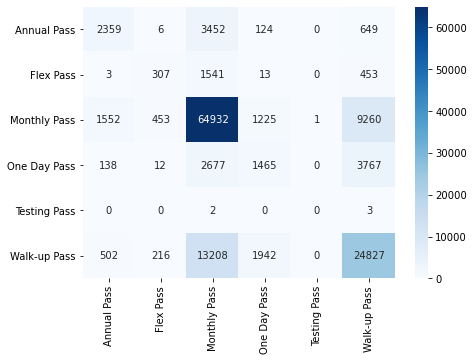

In [107]:
classifier = RandomForestClassifier(max_depth=100, n_estimators=50)
classifier.fit(x_train, y_train)

y_predict = classifier.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_predict)
print("Accuracy is: ", accuracy)


confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
# print("The confunsion matrix:\n",confusion_matrix)
print("\nAccuracy:",metrics.accuracy_score(y_test, y_predict))
print("\nPrecision:\n", metrics.precision_score(y_test, y_predict, average=None).reshape(-1,1))
print("\nRecall:\n", metrics.recall_score(y_test, y_predict, average=None).reshape(-1,1))
print(metrics.classification_report(y_test, y_predict, digits=3))

col = ['Annual Pass','Flex Pass','Monthly Pass','One Day Pass','Testing Pass','Walk-up Pass']
df_cm = pd.DataFrame(confusion_matrix, columns=col)
plt.figure(figsize=(7,5))
ax = sb.heatmap(df_cm, annot=True, fmt="d", cmap='Blues', xticklabels=True, yticklabels=col)

print(metrics.classification_report(y_test, y_predict))

### 10-Fold Cross-Validation with 

In [200]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']
rf = RandomForestClassifier(max_depth=100, n_estimators=50)
results = cross_validate(rf, x_train, y_train, cv=kfold, scoring=scoring)

print("Accuracy: ", round(results['test_accuracy'].mean()*100,2))
print("Precision: ", round(results['test_precision_macro'].mean()*100,2))
print("Recall: ", round(results['test_recall_macro'].mean()*100,2))
print("F1-score: ", round(results['test_f1_macro'].mean()*100,2))
print(round(results['test_accuracy'].std()*100,2))

Accuracy:  93.21
Precision:  87.12
Recall:  82.96
F1-score:  84.32
0.09


0------ Annual pass

1------ flex pass

2------ Monthly

3------ One day

4------ Testing

5------ Walk-up pass

# Utilizar el modelo entrenado para clasificar el conjunto de datos de prueba.

In [119]:
test_data = pd.read_csv("test_set.csv", dtype={
    'bike_id':'category',
    'trip_route_category':'category'})
test_data.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
0,17059130,12,1/1/2017 0:24,1/1/2017 0:36,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028
1,17059129,17,1/1/2017 0:28,1/1/2017 0:45,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018
2,17059126,20,1/1/2017 0:39,1/1/2017 0:59,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055
3,17059125,12,1/1/2017 0:43,1/1/2017 0:55,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079
4,17061379,48,1/1/2017 0:56,1/1/2017 1:44,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063


In [120]:
add_timeformat(test_data)

In [121]:
add_year(test_data)
test_data.head()

<ipython-input-12-166b627e646b>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'][i] = data['start_time'][i].year


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,year
0,17059130,12,2017-01-01 00:24:00,2017-01-01 00:36:00,34.058319,-118.246094,34.058319,-118.246094,6351,Round Trip,3028,3028,2017
1,17059129,17,2017-01-01 00:28:00,2017-01-01 00:45:00,34.049980,-118.247162,34.043732,-118.260139,5836,One Way,3027,3018,2017
2,17059126,20,2017-01-01 00:39:00,2017-01-01 00:59:00,34.063389,-118.236160,34.044159,-118.251579,6529,One Way,3066,3055,2017
3,17059125,12,2017-01-01 00:43:00,2017-01-01 00:55:00,34.048851,-118.246422,34.050140,-118.233238,6029,One Way,3029,3079,2017
4,17061379,48,2017-01-01 00:56:00,2017-01-01 01:44:00,34.049198,-118.252831,34.049198,-118.252831,6680,Round Trip,3063,3063,2017


In [122]:
to_be_encoded = test_data.loc[:,['trip_route_category']]

lab_enc = preprocessing.LabelEncoder()
encoding_tripRoute = lab_enc.fit_transform(to_be_encoded['trip_route_category'])
test_data['trip_route_category'] = encoding_tripRoute

In [123]:
test_data_2 = test_data[predictors_columns]
test_data_2.head()

,trip_route_category,duration,start_station,end_station,year
0,1,12,3028,3028,2017
1,0,17,3027,3018,2017
2,0,20,3066,3055,2017
3,0,12,3029,3079,2017
4,1,48,3063,3063,2017


In [124]:
y_test = classifier.predict(test_data_2)

In [125]:
y_test

array([5, 5, 2, ..., 5, 5, 5])

In [126]:
pd_y = pd.DataFrame(y_test, columns=['passholder_type'])
pd_y.head()

,passholder_type
0,5
1,5
2,2
3,5
4,5


In [127]:
pd_y['passholder_type'] = pd_y['passholder_type'].map({
    5: 'Walk-up',
    4: 'Testing',
    3: 'One Day Pass',
    2: 'Monthly Pass',
    1: 'Flex Pass',
    0: 'Annual Pass'
})



In [132]:
new_data = pd.concat([test_data,pd_y],axis=1)

In [133]:
new_data

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,year,passholder_type
0,17059130,12,2017-01-01 00:24:00,2017-01-01 00:36:00,34.058319,-118.246094,34.058319,-118.246094,6351,1,3028,3028,2017,Walk-up
1,17059129,17,2017-01-01 00:28:00,2017-01-01 00:45:00,34.049980,-118.247162,34.043732,-118.260139,5836,0,3027,3018,2017,Walk-up
2,17059126,20,2017-01-01 00:39:00,2017-01-01 00:59:00,34.063389,-118.236160,34.044159,-118.251579,6529,0,3066,3055,2017,Monthly Pass
3,17059125,12,2017-01-01 00:43:00,2017-01-01 00:55:00,34.048851,-118.246422,34.050140,-118.233238,6029,0,3029,3079,2017,Walk-up
4,17061379,48,2017-01-01 00:56:00,2017-01-01 01:44:00,34.049198,-118.252831,34.049198,-118.252831,6680,1,3063,3063,2017,Walk-up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569881,179408277,19,2021-12-31 23:29:00,2021-12-31 23:48:00,34.040989,-118.255798,34.041130,-118.267982,14027,0,3033,3011,2021,Monthly Pass
569882,179408276,8,2021-12-31 23:40:00,2021-12-31 23:48:00,34.044701,-118.252441,34.051941,-118.243530,20006,0,3031,3030,2021,Monthly Pass
569883,179409877,43,2021-12-31 23:47:00,2022-01-01 00:30:00,34.044701,-118.252441,34.044701,-118.252441,16214,1,3031,3031,2021,Walk-up
569884,179409876,42,2021-12-31 23:48:00,2022-01-01 00:30:00,34.044701,-118.252441,34.044701,-118.252441,13336,1,3031,3031,2021,Walk-up


In [135]:
columnas = ['trip_id','passholder_type']
new_data[columnas].to_csv('sample_submission2.csv', index=False)

In [137]:
new_data.passholder_type.unique()
new_data.groupby('passholder_type')['trip_id'].count()

passholder_type
Annual Pass      19121
Flex Pass         4162
Monthly Pass    361339
One Day Pass     20154
Testing             18
Walk-up         165092
Name: trip_id, dtype: int64